# MODS Atmospheric Differential Refraction Calculator

Computes the atmospheric properties using the Owens (1967, App.Opt., 6, 51) model of the index of refraction
of the Earth's atmosphere.  This program requires some site-specific parameters (nominal values for the air
pressure (in hPa), air temperature (in C), and relative humidity in percent).  You need to specify the nominal
guiding wavelength, since refraction in computed relative to the 
apparent position of the target as seen at the nominal guide wavelength.

Calculation is setup for the Large Binocular Telescope (LBT) on Mt. Graham and the Multi-Object Double
Spectrographs (MODS), but may be a template for use with other observatories and instruments.

We use our standard plotting setup for a 1:1 aspect ratio plot.


In [1]:
%matplotlib inline

import sys
import os
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord

# Plot setup 1:1 aspect ratio

aspect = 1.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

figFmt = 'png'
dpi = 600
plotWidth = dpi*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'14'})

# Font and line weight defaults for axes

plt.rcParams.update({'axes.linewidth':lwidth})
plt.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']='%d' % (axisPad)
plt.rcParams['ytick.major.pad']='%d' % (axisPad)
plt.rcParams['axes.labelpad'] = '%d' % (axisPad)

## Atmospheric index of refraction model functions

Here we define 4 useful functions based on Owens, J.C. 1967, Applied Optics, 6, 51 and references therein.

### Saturation pressure of water vapor $P_{s}(T)$

Computes the saturation pressure $P_{s}$ of atmospheric water vapor for a given air temperature $T$ in degrees C.  Returns $P_{s}$ in units of hPa., adopting Buck's 1991 variation of the formula originally from Buck, A.L. 1981, J. Applied Meteorology, 20, 1527.


In [2]:
def satPres(T):
    pSat = 6.1121*math.exp((18.679-(T/234.5))*(T/(257.4+T)))
    return pSat

### Dry-air density factor $D_{s}(T,P_{d})$

Given the air temperature $T$ in degrees C and partial pressure of dry air $P_{d}$ in hPA, compute the dimensionless dry-air density factor $D_{s}$ following Owens (1967) equation 30.

In [3]:
def dryDens(T,Pd):
    TK = T + 273.16  # Temperature in K
    
    Ds = (Pd/TK)*(1.0 + Pd*((5.790E-7) - (9.3250E-4/TK) + (0.25844/(TK*TK))))
    
    return Ds

### Water-vapor density factor $D_{w}(T,P_{w})$

Given the air temperature $T$ in degrees C and the partial pressure of water vapor $P_{w}$ in hPa, computes the dimensionless water-vapor density factor $D_{w}$ following Owens (1967) equation 31.

In [4]:
def wetDens(T,Pw):
    TK = T + 273.16  # Temperature in K
    
    Dw = (Pw/TK)*(1.0 + Pw*(1.0 + 3.7E-4*Pw)*
                  (-2.37321E-3 + (2.23366/TK) - (710.792/(TK*TK)) + (77514.1/(TK*TK*TK))))

    return Dw

### Group Index of Refraction of Air $n_{G}(\lambda,T,P,RH)$

Given the wavelength $\lambda$, air temperature $T$, pressure $P$, and relative humidity $RH$, computes the group index of refraction of air $n_{G}$ following Owens (1967) equation 42.

Units: $\lambda$ in nm, $T$ in C, $P$ in hPa, and $RH$ in percent (0..100).

This calculation uses the satPres(), dryDens(), wetDens() functions defined previously.

In [5]:
def refrac(lam,T,P,RH):
    Ps = satPres(T)  # saturation water vapor pressure
    Pw = Ps*(RH/100) # partial pressure of water vapor
    Pd = P - Pw      # partial pressure of dry air

    Ds = dryDens(T,Pd)
    Dw = wetDens(T,Pw)

    sig2 = (1000/lam)**2

    nDry = Ds*(2371.34 + (683939.7/(130-sig2)) + (4547.3/(38.9-sig2)))
    nWet = Dw*(6487.31 + 58.058*sig2 - 0.7115*(sig2*sig2) + 0.08851*(sig2*sig2*sig2))

    nG = 1.0e-8*(nDry + nWet)

    return nG

## Parallactic Angle and Airmass calculators

Functions to compute
 * `parAngle()` - parallactic angle given latitude, dec, and HA
 * `airMass()` - airMass given latitude, dec, and HA
 

In [6]:
def parAngle(lat,dec,ha):
    '''
    lat = latitude in decimal degrees
    dec = declination in decimal degrees
    ha = hour angle in hours
    
    returns parallactic angle in degrees
    '''
    latRad = math.radians(lat)
    decRad = math.radians(dec)
    haRad  = math.radians(15.0*ha)

    top = math.sin(haRad)
    bot = math.tan(latRad)*math.cos(decRad) - math.sin(decRad)*math.cos(haRad)
    parAng = math.degrees(math.atan2(top,bot))
    if parAng < -90:
        parAng = -(parAng + 180)
    if parAng > 90:
        parAng = 180 - parAng

    return parAng

def airMass(lat,dec,ha):
    '''
    lat = latitude in decimal degrees
    dec = declination in decimal degrees
    ha = hour angle in hours
    
    returns airMass (dimensionless)
    '''
    latRad = math.radians(lat)
    decRad = math.radians(dec)
    haRad  = math.radians(15.0*ha)

    cosZD = math.sin(latRad)*math.sin(decRad) + math.cos(latRad)*math.cos(decRad)*math.cos(haRad)
    if (cosZD > 0.0):
        am = 1.0/cosZD
        if am > 99.0:
            am = 99.99;
    return am

## Observatory Site & Observing Parameters

The observatory site and observing parameters needed are as follows:
 * `latitude`: observatory site latitude in degrees (+=North, $-$=South)
 * `siteP`: Nominal site air pressure in hPa
 * `siteT`: Nominal site air temperature in degrees Celsius
 * `siteRH`: Nominal site relative humidity in percent

We also define the wavelengths to compute and their corresponding colors for plot.

We put in the parameters typical of Mt. Graham, Arizona and the Large Binocular Telescope, which is at
an elevation of about 3300-meters.

In [7]:
# LBT site info

latitude = 32.70131 # latitude of the observatory site in degrees North
siteP  = 687.0      # nominal site air pressure in hPa
siteT  = -1.3       # nominal site air temperature in degrees Celsius
siteRH = 13.4       # nominal site relative humidity in percent

# wavelength and corresponding color table

lamTable = [350.0,450.0,550.0,650.0,750.0,850.0,950.0]  # units of nm
lamColor = [(0.7,0,0.7),(0,0,1),(0,1,0),(0,0,0),(1,0.5,0),(1,0,0),(0.733,0,0)]

## Observation circumstances

Change these to set the MODS observing and instrument configuration data
 * `coords` = 'ra dec' string with sexagesmial coordinates of the object in a format for astropy `SkyCoord`
 * `lamGuide` = nominal guiding wavelength in nm (e.g., 625nm for MODS long-pass filter)
 * `slitWidth` = slit width in arcseconds
 * `slitPA` = slit celestial position angle in decimal degrees from North to East
 * `startHA` = starting hour angle in decimal hours
 * `endHA` = ending hour angle in decimal hours
 * `dHA` = hour angle step in decimal hours

## Calculate and Plot

Plot the differential atmospheric refraction trajectories for the observation between (startHA..endHA) for the
given target declination, slit, and guide wavelength.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


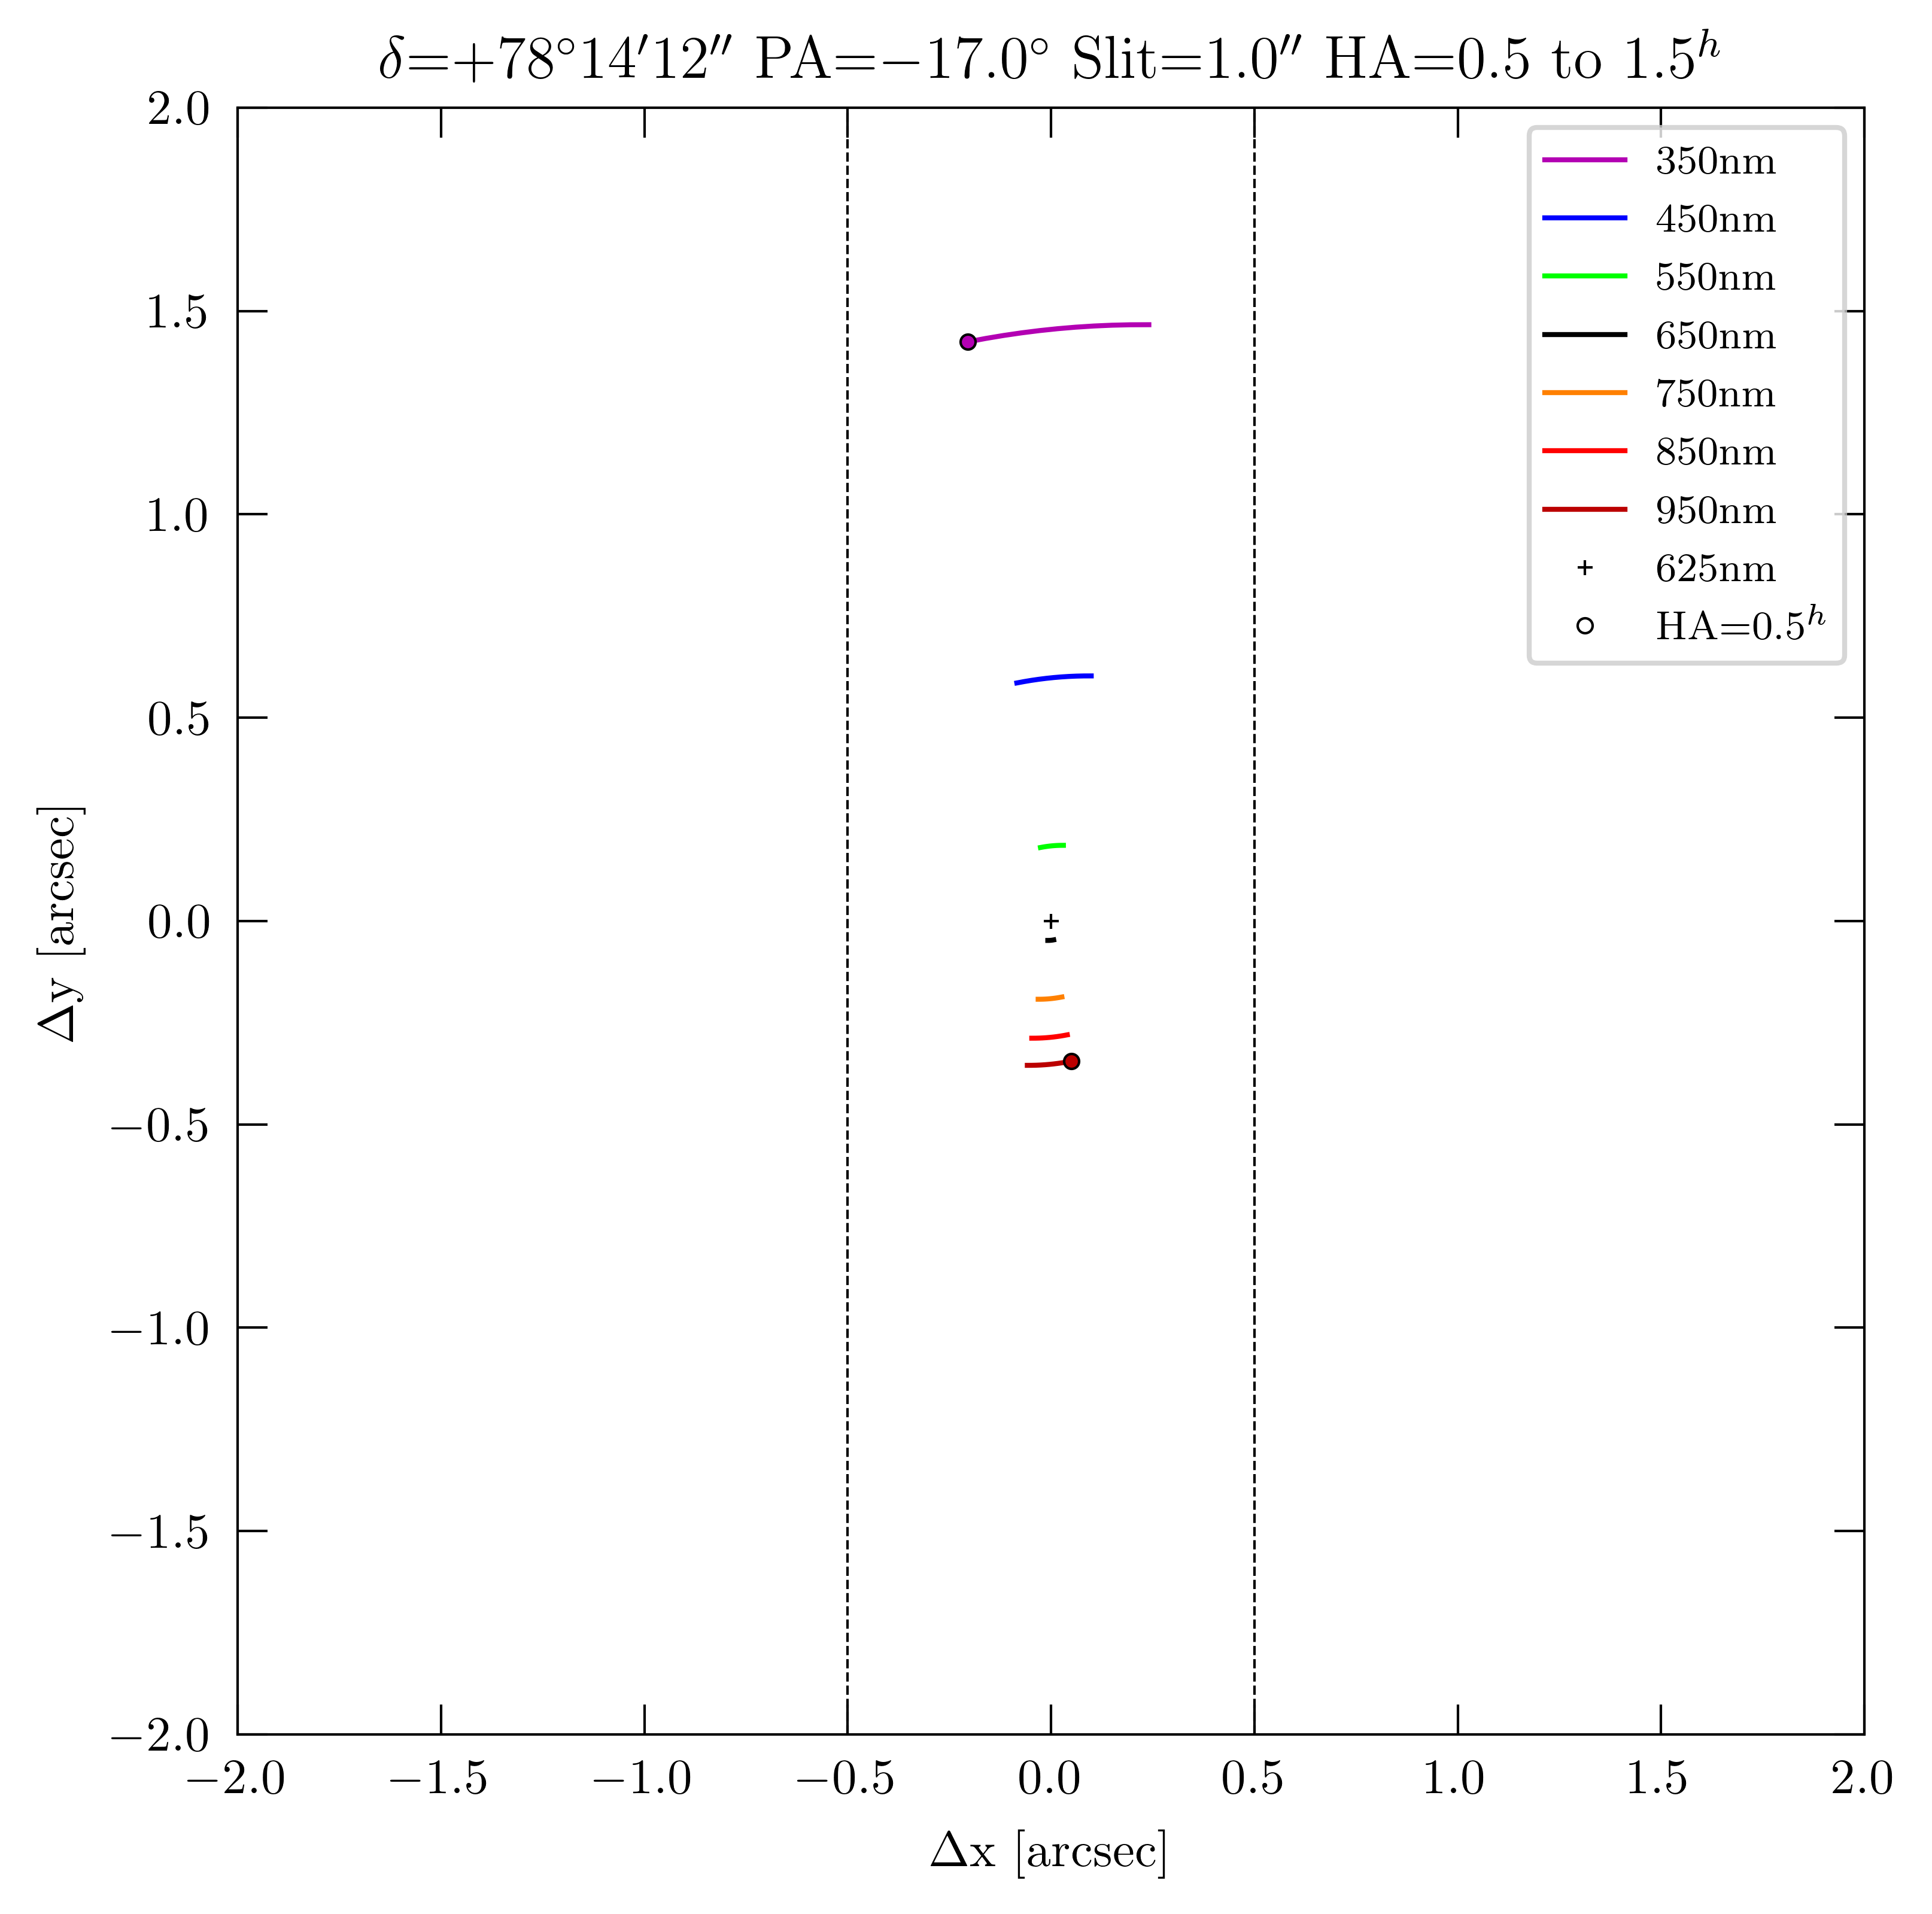

In [8]:
# object coordinates in sexagesimal hours and degrees

coords = '00:42:30 +78:14:12'  

# Guide wavelength in nm

lamGuide = 625.0 

# slit width

slitWidth = 1.0 # arcsec slit width

# Slit position angle

slitPA = -17.0 # degrees North to East

# Starting and ending Hour angle and HA step in decimal hours

startHA = 0.5 # decimal hours
endHA = 1.5
dHA = 0.1

#
# Nothing to change below this point!
#-------------------------------------------

# hour angles to calculate

numHA = 1 + int((endHA-startHA)/dHA)
haTable = np.linspace(startHA,endHA,numHA)

# get decimal and latex representations of the declination

objCoord = SkyCoord(coords,unit=(u.hourangle,u.deg),frame='icrs')

dec = objCoord.dec.degree
decStr = objCoord.dec.to_string(alwayssign=True,format='latex')

# index of refraction at the guiding wavelength

nGuide = refrac(lamGuide,siteT,siteP,siteRH)

# calculate dx,dy deflections as a function of airmass and wavelength

dx = []
dy = []
for lam in lamTable:
    dxha = []
    dyha = []
    for HA in haTable:
        # Compute the parallactic angle and PA of "up" along parallactic
        
        parAng = parAngle(latitude,dec,HA)
        if (dec > latitude):
            paUp = -parAng - 180
        else:
            paUp = parAng

        if (paUp > 180):
            paUp = paUp - 360
        if (paUp <= -180):
            paUp = paUp + 360

        # Compute the airmass (secZD)
        
        AM = airMass(latitude,dec,HA)
        if (AM > 0 and AM < 99):  # in valid range
            tanZD = math.tan(math.acos(1/AM))
            nLam = refrac(lam,siteT,siteP,siteRH)
            Rlam = 206264.8*tanZD*(nLam-nGuide)
            dxha.append(Rlam*math.sin(math.radians(paUp - slitPA)))
            dyha.append(-Rlam*math.cos(math.radians(paUp - slitPA)))
        else:
            dxha.append(-999.99)
            dyha.append(-999.99)

    # bottom of HA loop
    dx.append(dxha)
    dy.append(dyha)

# bottom of wavelength loop

# establish the plotting limits

dimMax = np.max([math.fabs(np.min(dx)),math.fabs(np.max(dx)),math.fabs(np.min(dy)),math.fabs(np.max(dy))])

if 1.5*dimMax > 1.0:
    halfSize = int(1.5*dimMax)
else:
    halfSize = 1.5*dimMax

if halfSize < 1.5:
    halfSize = 1.5
    
xMin = -halfSize
xMax =  halfSize
yMin = xMin
yMax = xMax

# Make the plot

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# limits, 1:1 aspect ratio, tight layout, black background

ax.set_xlim(xMin,xMax)
ax.set_xlabel(r'$\Delta$x [arcsec]')
ax.set_ylim(yMin,yMax)
ax.set_ylabel(r'$\Delta$y [arcsec]')
ax.set_aspect('equal')

# plot the curves by wavelength

for i,lam in enumerate(lamTable):
    lamLabel = f'{int(lam)}nm'
    ax.plot(dx[i],dy[i],'-',color=lamColor[i],lw=1,label=f'{int(lam)}nm')

# plot crosses at the starting red and uv points of the track

ax.plot(dx[0][0],dy[0][0],marker='o',ms=3,mew=0.5,mec='black',mfc=lamColor[0])
ax.plot(dx[-1][0],dy[-1][0],marker='o',ms=3,mew=0.5,mec='black',mfc=lamColor[-1])

plt.plot([],[],'+',ms=3,mew=0.5,color='black',label=fr'{int(lamGuide)}nm')
plt.plot([],[],'o',ms=3,mew=0.5,mfc='white',mec='black',label=fr'HA={startHA:.1f}$^h$')
plt.plot(0,0,'+',ms=3,mew=0.5,color='black')

# plot the slit overlay

xshw = 0.5*slitWidth
plt.vlines([-xshw,xshw],yMin,yMax,linestyles=['--'],colors=['black'],lw=0.5)

# plot title and legend
    
title = rf'$\delta$={decStr} PA=${slitPA:.1f}^\circ$ Slit={slitWidth:.1f}$^{{\prime\prime}}$ HA=${startHA:.1f}$ to ${endHA:.1f}^h$'
plt.title(title,fontsize=12)
plt.legend(fontsize=8)
plt.plot()

pngFile = 'modsADRplot.png'
plt.savefig(pngFile,bbox_inches='tight',facecolor='white')